# LTEM Image Simulation Example Notebook
This notebook gives examples of how to simulate and reconstruct Lorentz transmission electron microscopy (LTEM) images from a given magnetization over a 3D region. 

This notebook is part of the PyLorentz codebase for analyzing LTEM data. For background on LTEM and PyLorentz, please refer to our [documentation pages](https://pylorentztem.readthedocs.io/en/latest/). 

The notebook is broken into two primary sections: the first presents an all-in-one function that takes a magnetization vector output file, the various materials and imaging parameters, and returns a TIE reconstructed image set.  

The following section walks through the individual steps required:
* Calculating the phase shift from the magnetization
* Simulating LTEM images from the phase shift
* Reconstructing the integrated magnetic induction from the LTEM images  

If you have not yet worked through the TIE_template notebook we recommend you do so first, as the TIE reconstruction method will used here as well. 

Authors: Arthur McCray, CD Phatak
V1.0, ANL, June 2020

##### Using this notebook
While PyLorentz is intended to be used by individuals with some basic python knowledge, this template notebook will yield results by simply running the cells and is intended to be accessible for everyone. If you are new to Python or PyLorentz we recommend proceeding through the notebook as-is, before changing values and parameters. Code cells can be executed by pressing "Ctrl + Enter" while selected, and values are not stored/changed until executed.  



In [1]:
# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
%matplotlib widget
import sys 
import numpy as np 

sys.path.append("../..")
from PyLorentz.PyTIE.TIE_helper import show_im, show_2D
from PyLorentz.PyTIE.TIE_reconstruct import TIE, SITIE 
from PyLorentz.SimLTEM.sim_helper import * 
from PyLorentz.SimLTEM.comp_phase import mansPhi, linsupPhi

# Simulating from Micromagnetics Output 
The function "reconstruct_ovf()" begins with a micromagnetics vector output file (.omf or .ovf) and simulates then reconstructs a LTEM through focus series (tfs). The final return is the results dictionary output by TIE(), with some steps saved as set by the user. There are many parameters that need to be defined which fall into two primary categories: materials parameters and imaging conditions. 

### Materials Parameters
The micromagnetics output file contains the vector magnetization information, as well as voxel (3D pixel) size and physical dimensions of the sample. It does not, however, provide any materials information of the sample itself, so the user must specify that themself. Additionally, many samples will be on a substrate or membrane of some sort which we can account for while assuming it is of uniform thickness. The parameters relevant for electron microscopy, namely the mean inner potential and extinction distance, can occasionally be found for single elements in electron microscopy textbooks (such as Reimer & Kohl). 

The following arguments of `reconstruct_ovf()` are defined here: 
* `file`: The file path. This function can load OVF 2.1/2.0 text files as well as most binaries.
* `B0`: The saturation induction in gauss. 
* `sample_V0`: The sample mean inner potential in volts. 
* `sample_xip0`: The (000) extinction distance for the sample in nm. 
* `mem_thk`: The thickness of the membrane in nm. 
* `mem_xip0`: The extinction distance for the membrane in nm. 
* `thk_map`: 2D array (y,x). Thickness values as factor of total thickness (zscale\*zsize). If a 3D array is given, it will be summed along z-axis. Pixels with thickness=0 will not have the phase calculated as a method to reduce computation time.  Default None -> Uniform thickness as given by datafile, equivalent to array of 1's.

In [4]:
file = "/Volumes/Lorentz/Kayna/Simulations/Mumax3/2023_04_26/std_relax_nano.out/USAF_res_pattern_.ovf"
B0 = 1e4 # gauss
sample_V0 = 20 # V
sample_xip0 = 200 # nm
mem_thk = 50 # nm
mem_xip0 = 800 # nm

#### Looking at the raw magnetization data
Here we show the raw input data that we will use to simulate LTEM images. The example data is for a small region of permalloy artificial spin ice (ASI). The simulation area is a grid of size (1,500,500) with cubic voxels of length 5nm. The in-plane component of the magnetization is depicted with the same colorwheel we will use to show the final simulated integrated magnetic induction map, which serves to highlight how the output of a micromagnetics simulation is _not_ what you will observe in the microscope. The micrscope views (and TIE reconstructs) the integrated magnetic induction along the beam direction, and this can look very different from the magnetization. 

The majority of these images will be displayed with a hue-saturation-value (hsv) colorwheel, in which the color of each pixel corresponds to the magnetization angle and color intensity to magnitude. HSV wheels intrinsically have 3-fold emphasis (three primary and three secondary colors), but you can also use a 4-fold colorwheel by setting hsvwheel=False in the "show_im()" command. The matter of creating a "good" disc colormap which shows both azimuth and magnitude in a perceptually uniform way is not simple; more can be read about colormaps [in this paper by Peter Kovesi and on his website](https://peterkovesi.com/projects/colourmaps/).

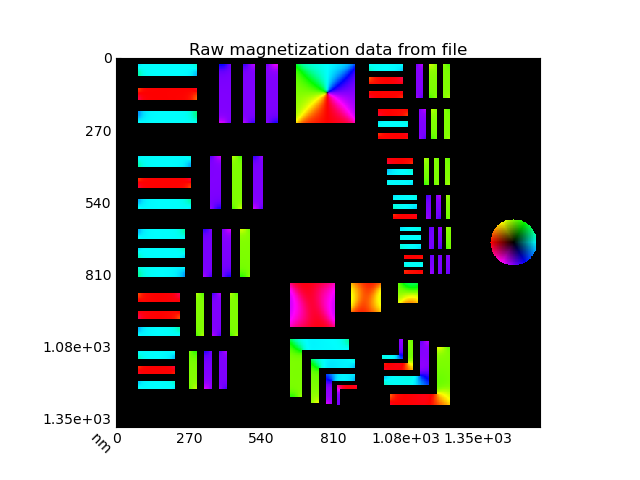

In [5]:
from PyLorentz.PyTIE.colorwheel import color_im
mag_x, mag_y, mag_z, del_px, zscale = load_ovf(file, 'norm', B0, v=0)
# The input ovf might be many layers thick, so we sum along the z-direction to 
# make a 2D image to display. 
show_im(color_im(np.sum(mag_x, axis=0), np.sum(mag_y,axis=0), hsvwheel=True), 
        title="Raw magnetization data from file", cbar=False, scale=del_px)

#### Defining the thickness map
As this data corresponds to an island structure, we will also create a thickness map. The micromagnetic output is a rectangular mesh with the space between islands denoted by a (0, 0, 0) magnetization vector. We create a map below that has a value of 0 where there is no magnetic material, and 1 where there is. As this sample is uniform in the z-direction we can use a 2D map by setting the optional argument ``D3=False``, though in general one should use a 3D map. 

If your sample is of uniform thickness, you can omit the optional argument "thk_map" and it will be populated with an array of ones.

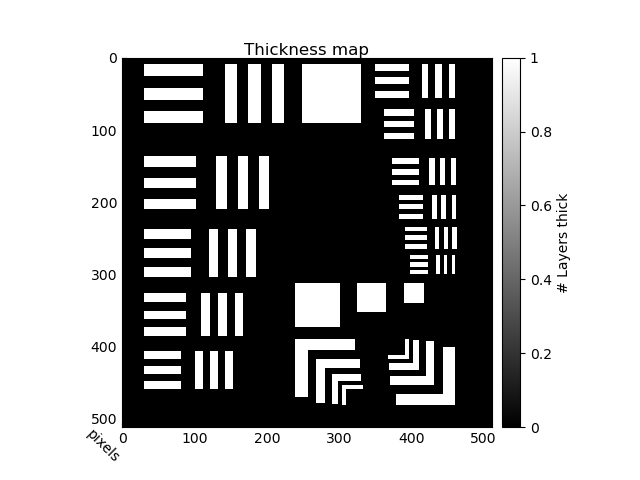

In [6]:
thk_map = make_thickness_map(mag_x, mag_y, mag_z)
show_im(thk_map.sum(axis=0), "Thickness map", cbar=True, cbar_title="# Layers thick")

### Imaging conditions
The final reconstruction is dependent on both the imaging conditions as well as the microscope itself. Microscope parameters are contained in a Microscope object (named pscope in the example below), making it easy to compare results in different simulated microscopes.  
Parameters (the default value is given for parameters where it might often be used): 
- `defval`: The defocus at which to simulate images in nm (in-focus and +/- defval will be used for the tfs)
- `theta_x`: The sample tilt around the x-axis (degrees). Default 0. 
- `theta_y`: The sample tilt around the y-axis (degrees). Default 0. 
- `add_random`: Whether to account for amorphous background in the sample. add_random=1 provides a moderate amount of background as scaled by the electrostatic phase shift. Other float values can be used to increase/decrease the intensity. Default 0. 
- `flip`: Whether to use a single tfs (False) or calculate a tfs for the sample in both orientations. For flat samples a single tfs is fine, though it's needed for samples with variable thickness (which can be controlled with the thk_map array). Default True. 

In [7]:
pscope = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0, verbose=True)
defval = 100_000 # nm
theta_x = 0 # degrees
theta_y = 0 # degrees
add_random = 0 # unitless scaling factor
flip=False # Bool


            Creating a new microscope object with the following properties:
            Quantities preceded by a star (*) can be changed using optional arguments at call.
            ------------------------------------------------------------------
            *Accelerating voltage               E: [V]    {self.E: 4.4g}
            *Spherical Aberration             Cs: [nm]    {self.Cs: 4.4g}
            *Chromatic Aberration             Cc: [nm]    {self.Cc: 4.4g}
            *Beam Coherence             theta_c: [rad]    {self.theta_c: 4.4g}
            *2-fold astigmatism               Ca: [nm]    {self.Ca: 4.4g}
            *2-fold astigmatism angle     phi_a: [rad]    {self.phi_a: 4.4g}
            *defocus spread              def_spr: [nm]    {self.def_spr: 4.4g}
            Electron wavelength           lambda: [nm]    {self.lam: 4.4g}
            Relativistic factor             gamma: [-]    {self.gamma: 4.4g}
            Interaction constant       sigma: [1/V/nm]    {self.sig

### Calculation Parameters and Run

Finally there are some parameters that control the outputs given. 
* `savename`: String that will prepend all saved files.
* `method`: String. Method of phase calculation to use if theta_x == 0 and theta_y == 0. If either are nonzero then the linear superposition method will be used automatically. The Mansuripur algorithm is faster, but only works for 2D magnetizations and does not handle sample tilt very well. 
    - "Mans" : Default. Use Mansuripur algorithm if applicable. 
    - "Linsup" : Force using the linear superposition method. 
* `save`: Integer to control the amount of output that is saved; if saving, images and parameters files will be saved to subdirectories of wherever the datafile is located. "/sim_tfs/" will contain the tfs of the unflip and flip simulated images and a params.txt file with basic simulation parameters. "/images/" will contain TIE reconstruction output images. 
    - 0: Saves nothing, still returns results. 
    - 1: Default. Saves simulated images, simulated phase shift, and reconstructed integrated magnetic induction as both a colormap image and greyscale x/y components. 
    - 2: Saves simulated images, simulated phase shift, and all reconstruction TIE images. 
* `v`: Verbosity
    - 0: Suppress all output
    - 1: Default. Standard output with progress on phase shift calculations and displaying resulting image. 
    - 2: Extended output. Prints full datafile header and shows simulated phase shifts and tfs. 

reconstruct_ovf() returns a results dictionary containng the output reconstructed data and simulated phases, as well as a TIE_params object which contains the simulated image stacks. 


Text file found
Simulation size (z, y, x) : (1, 512, 512)
Image (x-y) scale : 2.7 nm/pixel.
Out-of-plane (z) scale : 10 nm/pixel.
Calculating phase shift with Mansuripur algorithm. 
Aligning for defocus value: 100000, with only unflip tfs.
Reconstructing with normal Laplacian method
Calling TIE solver



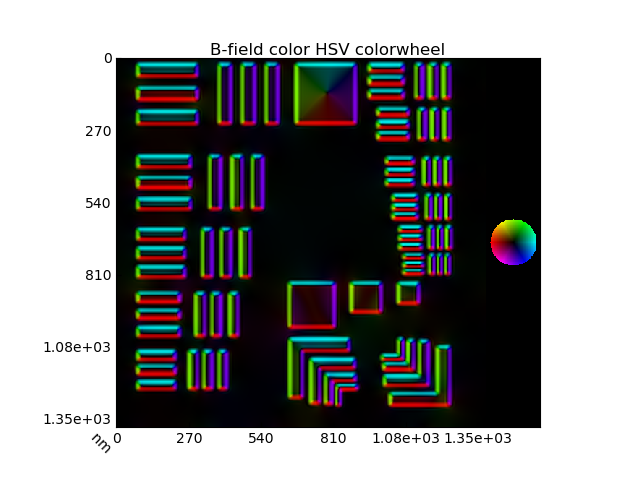

Phase reconstruction completed.


In [9]:
#savename = '/Users/klmendozatrujillo/Library/CloudStorage/Box-Box/KLMT_Work/Micromagnetic_Simulations/2023_04_28/PyLo_Nano_mans_'

savename = 'PyLo_Nano_mans_'
method = "mans" # use mansuripur algorithm if no sample tilt
save=0
v=1

results, ptie = reconstruct_ovf(file=file, save=save, savename=savename, v=v, 
                          flip=flip, pscope=pscope, defval=defval, theta_x=theta_x, 
                          theta_y=theta_y, add_random=add_random, thk_map=thk_map,
                          B0=B0, sample_V0=sample_V0, sample_xip0=sample_xip0, 
                          mem_thk=mem_thk, mem_xip0=mem_xip0, method=method)

In [ ]:
results

In [ ]:
objwave = results["objwave"]
amp = results["amp"]

print("Object Wave Array:", objwave)
print("Amplitude:", amp)



# Individual Simulation Steps
Here we show each of the main steps that takes place in reconstruc_ovf(), using a vortex state to use as an example. Unlike the magnetic islands file, here our sample is of uniform thickness so we won't need to simulate a flipped stack of images or define a thickness map. 

#### Creating a sample magnetization. 
The dimensions are small to reduce computation time. 

Summing along first axis


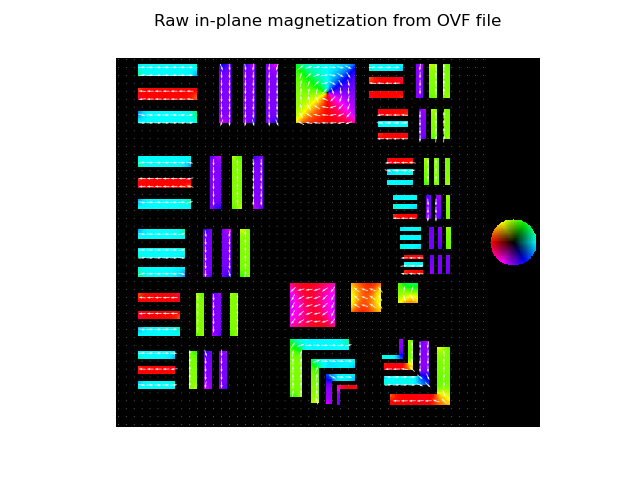

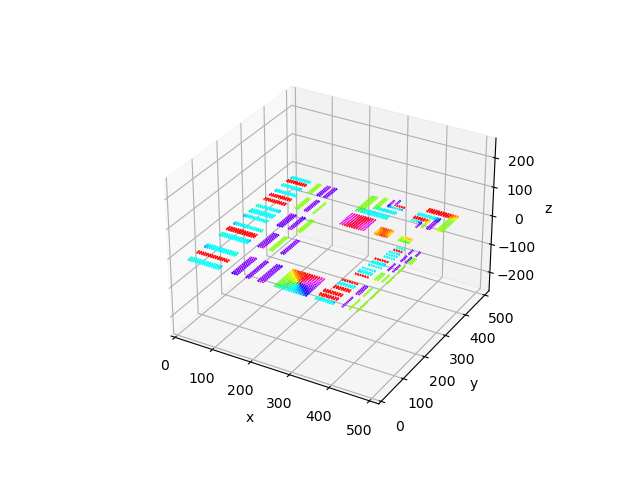

In [5]:
file = "/Volumes/Lorentz/Kayna/Simulations/Mumax3/2023_04_26/std_relax_nano.out/USAF_res_pattern_.ovf"
B0 = 1e4 # gauss
sample_V0 = 20 # V
sample_xip0 = 200 # nm
mem_thk = 50 # nm
mem_xip0 = 800 # nm

mag_x, mag_y, mag_z, del_px, zscale = load_ovf(file, 'norm', B0, v=0)
# The input ovf might be many layers thick, so we sum along the z-direction to 
# make a 2D image to display. 
show_2D(mag_x,
        mag_y,
        a=50,
        l=0.10,
        w=1.0,
        title="Raw in-plane magnetization from OVF file",
        color=True
        )

show_3D(mag_x,
        mag_y,
        mag_z,
        show_all = True, 
        l=4, 
        a = 100
        )

In [ ]:
dim = 128
del_px = 500/dim # nm/pixel
zscale = 10 # nm/pixel in the z-direction
b0 = 1e4 # Gauss 
V0 = 10 # V
Bloch_x, Bloch_y, Bloch_z = Bloch(dim, chirality = 'cw', pad = True, ir=0)
show_2D(Bloch_x, Bloch_y, a=20, l=0.15, w=0.75, title='in-plane magnetization', color=True)
show_3D(Bloch_x, Bloch_y, Bloch_z, show_all = True, l=2, a = 50)

## Getting magnetic and electrostatic phase shift with the linear superposition method  
This is one of the techniques used in reconstruct_ovf() to calculate the phase shift of an electron through a given magnetization. It has advantages of being applicable for 3D structures when tilting the sample, but it is much slower than the Mansuripur algorithm that will be shown next. 

The code is sped up using just-in-time compilation and multiprocessing with [numba](https://numba.pydata.org/), but the first time executing linsupPhi it will take an additional 5-10 seconds as the program compiles, and maybe longer depending on the cpu. Subsequent runs will be much faster, taking ~0.09 seconds for (1,64,64) and ~1.6 seconds for (1,128,128) arrays on a moderately powerful 8-core laptop. The total computation time of course depends on your cpu speed and number of cores, along with the image size and number of nonzero voxels. A larger in-plane (y,x) size will increase the computation time faster than adding depth: a (4,64,64) array takes ~0.33 seconds even though it has the same number of voxels as (1,128,128). 

The phase shifts due to the magnetic and electrostatic components are displayed seperately. Because this sample is of uniform thickness, there is no variation in the electrostatic phase shift and the only contrast is the small amount of noise from the Fourier transforms. 

In [ ]:
phi0 = 2.07e7 # Gauss*nm^2 
pre_B = 2*np.pi*b0*zscale*del_px/phi0
thickness_nm = zscale * 1 # 1 layer only, so thickness is just 10nm
pre_E = Microscope().sigma*V0*thickness_nm

ephi_L, mphi_L = linsupPhi(mx=Bloch_x.reshape(1,dim,dim),
                           my=Bloch_y.reshape(1,dim,dim),
                           mz=Bloch_z.reshape(1,dim,dim), 
                           pre_B=pre_B,
                           theta_x=0,
                           pre_E=pre_E)
show_im(mphi_L, "Magnetic phase shift from linear superposition method", scale=del_px, cbar_title="radians")
# show_im(ephi_L, "Electrostatic phase shift from linear superposition method (rad)")

## Calculating the phase shift with the Mansuripur algorithm  
The Mansuripur algorithm is an established technique for calculating phase shifts through 2D magnetizations. It has the advantage of being much faster than the linear superposition method, though not as flexible. For more details seee [this paper by Mansuripur](https://doi.org/10.1063/1.348682).

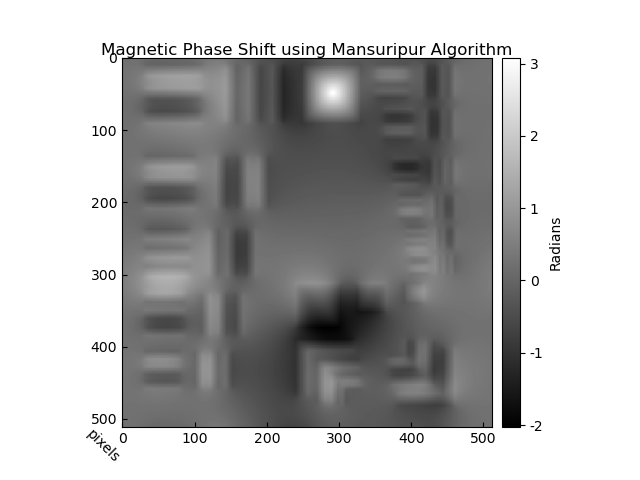

In [7]:
phi0 = 2.07e7   # Gauss*nm^2
b0 = B0
V0 = sample_V0
thickness_nm = zscale * 1 # 1 layer only, so thickness is just 10nm
# pre_B = 2*np.pi*b0*zscale*del_px/phi0
# pre_E = Microscope().sigma*V0*thickness_nm

ephi_m, mphi_m = std_mansPhi(mag_x,
                              mag_y,
                              mag_z,
                              isl_thk=zscale*1,
                              zscale=zscale,
                              del_px=del_px,
                              b0=b0,
                              isl_V0=V0
                              )

show_im(mphi_m,
        title="Magnetic Phase Shift using Mansuripur Algorithm",
        cbar_title="Radians"
        )

# show_im(ephi_m,
        # title="Electrostatic Phase Shift from Mansuripur algorithm"
        # ) # usually "null" or "uniform"


In [ ]:
# Apply mansuripur algorithm with some standard materials parameters. 
ephi_m, mphi_m = std_mansPhi(Bloch_x, Bloch_y, Bloch_z, 
                             isl_thk=zscale*1, # thickness of the magnetic structure in nm, 1 layer thick here
                             zscale=zscale, 
                             del_px=del_px,
                             b0=b0, isl_V0=V0)
show_im(mphi_m, title="magnetic phase shift from Mansuripur algorithm", cbar_title="radians")
# show_im(ephi_m, title="electrostatic phase shift from Mansuripur algorithm")

## Simulating LTEM images from the phase shift
In this section we take the calculated electron phase shift through the material and simulate the LTEM images that result from that phase shift. This is where the microscope parameters make a large difference, and you can simulate what the same material will look like given different imaging conditions. 

We also add noise in the form of small, random phase shifts that would result experimentally from the amorphous substrate or sample. The amount of noise is controlled by a unitless scaling paramter. 

Total fov is (1.38e+03,1.38e+03) nm


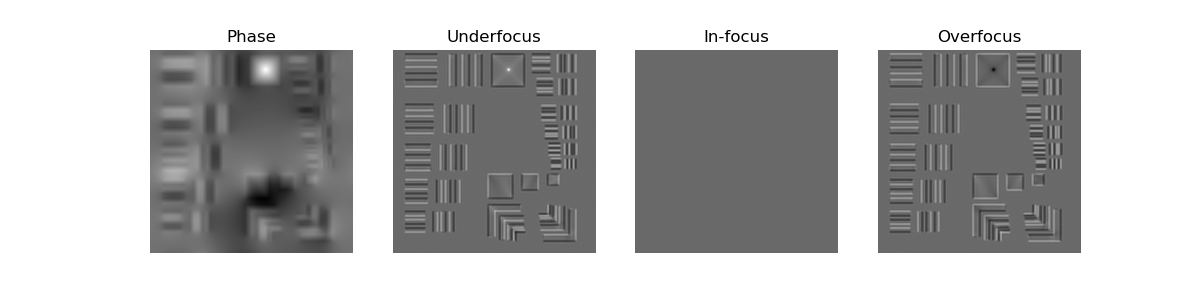

In [18]:
# using the linear superposition phase 
ALTEM = Microscope(E=200e3,
                   Cs = 200.0e3, 
                   theta_c = 0.01e-3, 
                   def_spr = 80.0)
defval = 100_000 # nm 
amorphous_noise = 0.2 # unitless scaling parameter 
Amp, ObjWave, Tphi, im_un, im_in, im_ov = sim_images(mphi=mphi_m, ephi=ephi_m, 
                                       pscope=ALTEM,
                                       del_px=del_px, 
                                       def_val=defval,
                                       add_random=amorphous_noise)
show_sims(Tphi, im_un, im_in, im_ov,
          save="/Users/klmendozatrujillo/Library/CloudStorage/Box-Box/0_KLMT_Work/1_ Micromagnetic_Simulations/2023_05_03_USAF_sims_/LTEM_sim_nano.tiff" #"/filepath/"
          )

np.save(file="/Users/klmendozatrujillo/Library/CloudStorage/Box-Box/0_KLMT_Work/1_ Micromagnetic_Simulations/2023_05_03_USAF_sims_/LTEM_sim_nano_objwave.npy",
        arr=ObjWave,
        allow_pickle=False
        )

np.save(file="/Users/klmendozatrujillo/Library/CloudStorage/Box-Box/0_KLMT_Work/1_ Micromagnetic_Simulations/2023_05_03_USAF_sims_/LTEM_sim_nano_amplitude.npy",
        arr=Amp,
        allow_pickle=False
        )

In [29]:
print("ObjWave_Min:", np.min(ObjWave))
print("ObjWave_Max:", np.max(ObjWave))
print("Amp_Min:", np.min(Amp))
print("Amp_Max:", np.max(Amp))

ObjWave_Min: (-0.6367259339228656+0.03390788714523266j)
ObjWave_Max: (0.6376281516216652-3.713148408263125e-07j)
Amp_Min: 0.6376281516217733
Amp_Max: 0.6376281516217733


In [30]:
amp = np.load(file="/Users/klmendozatrujillo/Library/CloudStorage/Box-Box/0_KLMT_Work/1_ Micromagnetic_Simulations/2023_05_03_USAF_sims_/LTEM_sim_nano_amplitude.npy",
        mmap_mode="r+",
        allow_pickle=False,
        fix_imports=False
        )

objwave = np.load("/Users/klmendozatrujillo/Library/CloudStorage/Box-Box/0_KLMT_Work/1_ Micromagnetic_Simulations/2023_05_03_USAF_sims_/LTEM_sim_nano_objwave.npy",
                  mmap_mode="r+",
                  allow_pickle=False,
                  fix_imports=False
                  )

print("objwave_Min:", np.min(ObjWave))
print("objwave_Max:", np.max(ObjWave))
print("amp_Min:", np.min(Amp))
print("amp_Max:", np.max(Amp))

if ObjWave.all() == objwave.all():
    print("These two arrays are equivalent")
else:
    print("Data is not equivalent, check code")

objwave_Min: (-0.6367259339228656+0.03390788714523266j)
objwave_Max: (0.6376281516216652-3.713148408263125e-07j)
amp_Min: 0.6376281516217733
amp_Max: 0.6376281516217733
These two arrays are equivalent


# Full example simulating and reconstructing images from a given magnetization
We now take those simulated images and feed them into the TIE reconstruction routine. There are few things to note here with regards to the TIE_params object: 
* Because we specified a uniformly thin sample, we do not need to use a through focus series of the flipped sample and can set flip=False. 
* As these are simulated images, we do not need to worry about edge effects and 0 regions that occur in the alignment and set no_mask=True
* If we were loading experimental .dm3 images, we would extract the scale directly from the infocus image. Instead we call ptie.set_scale(scale) which sets the scale specified in the necessary places. 

Setting scale: 2.7000 nm/pix

Aligning for defocus value: 100000, with only unflip tfs.
Reconstructing with normal Laplacian method
Calling TIE solver



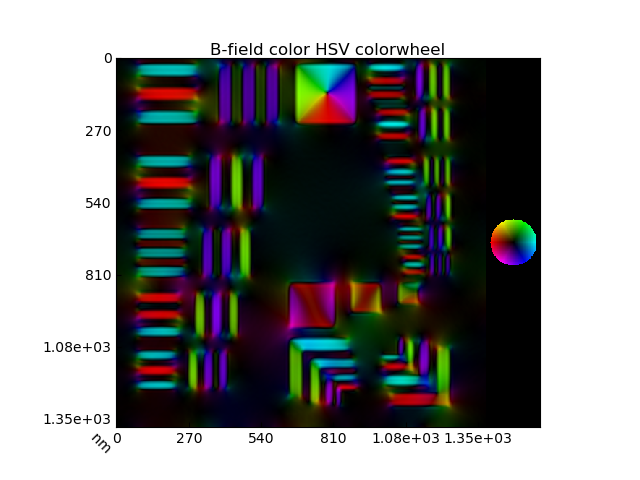

Saving images
Phase reconstruction completed.


In [39]:
data_loc = '/Users/klmendozatrujillo/Library/CloudStorage/Box-Box/0_KLMT_Work/1_ Micromagnetic_Simulations/2023_05_03_USAF_sims_/TIE/' # working directory, images will be saved to ptie.data_loc/Images

ptie = TIE_params(imstack=[im_un, im_in, im_ov], defvals=[defval], scale=del_px, 
                  flip=False, no_mask=True, data_loc=data_loc)

dataname = f'USAF_Nanoscale_' 
save = True

results = TIE(ptie=ptie, pscope=ALTEM, dataname=dataname, save=save)

### Single Image TIE (SITIE) Reconstruction 
In this example, the sample is uniformly flat and the only source of contrast in our images is magnetic Fresnel contrast, so we can actually reconstruct with just a single image. For more information on this technique please refer to [this paper by Chess et. al](https://doi.org/10.1016/j.ultramic.2017.02.004). 

There are two ways to run SITIE:

SITIE can also be called on just an image without loading it into a TIE_params object. In this case the arguments needed are: 
* `image`: 2D array. The image to be reconstructed
* `defval`: float. The defocus value of the image (negative for underfocused images)
* `scale`: float. The scale of the image in nm/pixel
* `E`: float. Accelerating voltage of the microscope which took the image. 

In [ ]:
results_SITIE = SITIE(image=im_un, defval=-1*defval, scale=del_px, E=200e3,
                       save=False, dataname="Example_SITIE2")

# Other single layer skyrmion magnetization structures
Here we show an alternate method of defining a skyrmion magnetization structure as described in [a paper by Lillihook et. al](https://doi.org/10.1016/S1386-9477(97)00013-1), as well as some alternate methods of plotting the vector information. 

In [ ]:
dim = 64
# Creating a Q=2 biskyrmion
Bloch_x2, Bloch_y2, Bloch_z2 = Lillihook(dim, Q=2, gamma=3*np.pi/2)
show_3D(Bloch_x2, Bloch_y2, Bloch_z2, show_all=True, l=2, a = 50)

In [ ]:
show_2D(Bloch_x2, Bloch_y2, a=60, l=0.5, color=False, title="in-plane magnetization component of a biskyrmion")
show_2D(Bloch_x2, Bloch_y2, Bloch_z2, a=60, l=0.5, color=True, title="in-plane magnetization component of a biskyrmion")

In [ ]:
anti_x, anti_y, anti_z = Lillihook(dim, rad=dim//8, Q = -1, show=False)
show_2D(anti_x, anti_y, l=0.25, a = 50, color=True, title="in-plane magnetization component of an antiskyrmion")
show_3D(anti_x, anti_y, anti_z, show_all = False, l=3, a = 50)

--- End Notebook ---